## Import Package

In [1]:
import os
import json
import numpy as np
import urllib.request
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
training_dataset_path = "../input/dogs-cats-images/dataset/training_set/"
validation_dataset_path = "../input/dogs-cats-images/dataset/test_set/"

training_dataset_cat_path = training_dataset_path + "cats"
training_dataset_dog_path = training_dataset_path + "dogs"

validation_dataset_cat_path = validation_dataset_path + "cats"
validation_dataset_dog_path = validation_dataset_path + "dogs"

In [3]:
print("Number of training images for dog: ", len(os.listdir(training_dataset_dog_path)))
print("Number of training images for cat: ", len(os.listdir(training_dataset_cat_path)))

Number of training images for dog:  4000
Number of training images for cat:  4000


In [4]:
print("Number of validation images for dog: ", len(os.listdir(validation_dataset_dog_path)))
print("Number of validation images for cat: ", len(os.listdir(validation_dataset_cat_path)))

Number of validation images for dog:  1000
Number of validation images for cat:  1000


## Create ImageDataGenerator

### Create ImageDataGenerator for Training

In [5]:
training_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=90,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2, 
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                fill_mode="nearest",
                                                                horizontal_flip=True,
                                                                rescale=1/255)

In [6]:
training_generator = training_datagen.flow_from_directory(directory=training_dataset_path, 
                                                          target_size=(300, 300),
                                                          class_mode="categorical",
                                                          batch_size=32)

Found 8000 images belonging to 2 classes.


### Create ImageDataGenerator for Validation

In [7]:
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [8]:
validation_generator = training_datagen.flow_from_directory(directory=validation_dataset_path, 
                                                          target_size=(300, 300),
                                                          class_mode="categorical",
                                                          batch_size=32)

Found 2000 images belonging to 2 classes.


## Define Model

### Architecture

In [9]:
# load pre-defined model architecture from keras
pre_trained_model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                                    weights=None,
                                                    input_shape=(300, 300, 3))

In [10]:
# download pre-trained weight
pre_trained_weight_name = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
urllib.request.urlretrieve("https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5", pre_trained_weight_name)

('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x7f3c487c5ed0>)

In [11]:
# load pre-trained weight to model
pre_trained_model.load_weights(pre_trained_weight_name)

In [12]:
# lock layer in pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [14]:
# the output of pre-trained model
pre_trained_model_output = pre_trained_model.output

# append customed layer to create new model
x = keras.layers.Flatten()(pre_trained_model_output)
x = keras.layers.Dense(units=1024, activation=tf.nn.relu)(x)

# create model without dropout layer
outputs = keras.layers.Dense(units=2, activation=tf.nn.softmax)(x)
model = keras.models.Model(inputs=pre_trained_model.input, outputs=outputs)

# create model with dropout layer
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(units=2, activation=tf.nn.softmax)(x)
model_dropout = keras.models.Model(inputs=pre_trained_model.input, outputs=outputs)

In [ ]:
model.summary()

In [ ]:
model_dropout.summary()

### Compilation

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["acc"])

In [18]:
model_dropout.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["acc"])

### Callback

In [19]:
pass

## Train Model

In [ ]:
history = model.fit(x=training_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    steps_per_epoch=32,
                    validation_steps=32)

In [21]:
with open("history.json", "w") as file:
    json.dump(history.history, file)

In [ ]:
history_dropout = model_dropout.fit(x=training_generator,
                                    epochs=100,
                                    validation_data=validation_generator,
                                    steps_per_epoch=32,
                                    validation_steps=32)

In [23]:
with open("history_dropout.json", "w") as file:
    json.dump(history_dropout.history, file)

## Compare Training Performace of Two Models

In [24]:
with open("history.json", 'r') as file:
    data = file.read()

history = json.loads(data)

In [25]:
with open("history_dropout.json", 'r') as file:
    data = file.read()

history_dropout = json.loads(data)

In [26]:
training_acc = history["acc"]
training_val_acc = history["val_acc"]
dropout_training_acc = history_dropout["acc"]
dropout_training_val_acc = history_dropout["val_acc"]
epochs = list(range(len(training_acc)))

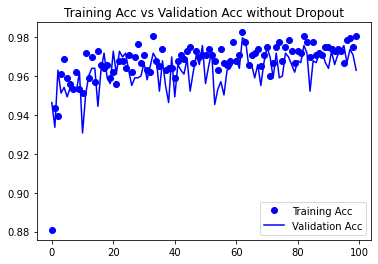

In [27]:
plt.plot(epochs, training_acc, 'bo', label="Training Acc")
plt.plot(epochs, training_val_acc, 'b', label="Validation Acc")
plt.title("Training Acc vs Validation Acc without Dropout")
plt.legend()
plt.show()

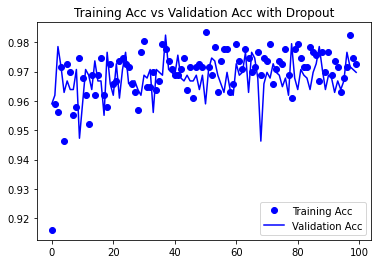

In [28]:
plt.plot(epochs, dropout_training_acc, 'bo', label="Training Acc")
plt.plot(epochs, dropout_training_val_acc, 'b', label="Validation Acc")
plt.title("Training Acc vs Validation Acc with Dropout")
plt.legend()
plt.show()